In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import xgboost as xgb
import lightgbm as lgbm

from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
dist = pd.read_csv('DIST.csv')

In [3]:
inmet = pd.read_csv('inmet.csv', sep=';')
inmet.head()

,id_estacaometeo,id_varmeteo,nom_varmeteo,nom_longo,din_medicao,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude
0,A701,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,São Paulo - Mirante de Santana,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,20.6,792.06,-23.496294,-46.620087
1,A705,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Bauru,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,19.3,550.00,-22.358051,-49.028877
2,A706,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Campos do Jordão,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,18.3,1580.00,-22.750278,-45.603890
3,A707,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Presidente Prudente,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,14.5,435.55,-22.119867,-51.408638
4,A708,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Franca,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,17.3,1003.00,-20.584444,-47.382500


In [4]:
inmet.shape

(4941669, 10)

In [5]:
cargas = pd.read_csv('seriesCargaSP.csv', sep=';', decimal=',')

In [6]:
cargas.nom_seriehistorica.unique()

array(['SP-ENERGISA SSE-SP', 'SP-EDP SP', 'SP-CPFL SANTA CRUZ',
       'SP-ELETROPAULO', 'SP-CPFL PIRATININGA', 'SP-ELEKTRO',
       'SP-CPFL PAULISTA'], dtype=object)

In [7]:
cargas['nom_seriehistorica'] = cargas['nom_seriehistorica'].apply(lambda x:   390 if x == 'SP-ELETROPAULO' else
                                                                              385 if x == 'SP-ELEKTRO' else
                                                                              391 if x == 'SP-EDP SP' else
                                                                              5216 if x == 'SP-ENERGISA SSE-SP'  else
                                                                              63 if x == 'SP-CPFL PAULISTA' else
                                                                              2937 if x == 'SP-CPFL PIRATININGA' else
                                                                              69 )

In [8]:
cargas.nom_seriehistorica.unique()

array([5216,  391,   69,  390, 2937,  385,   63], dtype=int64)

In [9]:
#ENEL, ELEKTRO, EDP, SSE, CPFLpl, CPFLpr, CPFLsc
# IdAgente = [390,385,391,5216,63,2937,69]

In [10]:
dist.DIST.unique()

array([ 390,  385,  391, 5216,   63, 2937,   69], dtype=int64)

In [11]:
dist.head()

,Unnamed: 0,Unnamed: 0.1,DIST,CONJ,MUN,CLAS_SUB,CNAE,GRU_TAR,SIT_ATIV,DAT_CON,CAR_INST,geometry
0,0,0.0,390,12826.0,35,RE1,0000-0/00,B1,AT,01/07/1972,0.3,NaN
1,1,1.0,390,12826.0,35,RE1,0000-0/00,B1,AT,01/06/1967,12.0,NaN
2,2,2.0,390,12826.0,35,RE1,0000-0/00,B1,AT,01/04/1978,7.0,NaN
3,3,3.0,390,12826.0,35,RE1,0000-0/00,B1,AT,28/06/2000,9.9,NaN
4,4,4.0,390,12826.0,35,CO1,8513-9/00,B3,AT,15/12/2007,2.8,NaN


In [12]:
dist.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'CONJ', 'MUN', 'CLAS_SUB', 'CNAE', 'DAT_CON'], axis=1, inplace=True)

In [13]:
dist.drop(columns='geometry', axis=1,inplace=True)

In [14]:
dist.drop(columns='GRU_TAR', axis=1,inplace=True)

In [15]:
dist.head()

,DIST,SIT_ATIV,CAR_INST
0,390,AT,0.3
1,390,AT,12.0
2,390,AT,7.0
3,390,AT,9.9
4,390,AT,2.8


In [16]:
dist.SIT_ATIV.unique()

array(['AT', 'DS', '0'], dtype=object)

In [17]:
cargas['id_estacaometeo'] = cargas['nom_seriehistorica'].apply(lambda x: 'A701' if x == 'SP-ELETROPAULO' else
                                                                         'A729' if x == 'SP-ELEKTRO' else
                                                                         'A728' if x == 'SP-EDP SP' else
                                                                         'A707' if x == 'SP-ENERGISA SSE-SP'  else
                                                                         'A737' if x == 'SP-CPFL PAULISTA' else
                                                                         'A713' if x == 'SP-CPFL PIRATININGA' else
                                                                         'A725' )

In [18]:
cargas.head(3)

,nom_seriehistorica,din_ocorrencia,val_itemserieoriginal,id_estacaometeo
0,5216,2018-01-01 00:00:00.000,368.049011,A725
1,5216,2018-01-01 01:00:00.000,360.519012,A725
2,5216,2018-01-01 02:00:00.000,350.457001,A725


In [19]:
inmet.head(3)

,id_estacaometeo,id_varmeteo,nom_varmeteo,nom_longo,din_medicao,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude
0,A701,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,São Paulo - Mirante de Santana,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,20.6,792.06,-23.496294,-46.620087
1,A705,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Bauru,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,19.3,550.00,-22.358051,-49.028877
2,A706,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Campos do Jordão,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,18.3,1580.00,-22.750278,-45.603890


In [20]:
inmet['distribuidora'] = inmet['id_estacaometeo'].replace(['A701', 'A729', 'A728', 'A707', 'A737', 'A713', 'A725'], [390, 385, 391, 5216, 63, 2937, 69])

In [136]:
inmet.head()

,id_estacaometeo,id_varmeteo,nom_varmeteo,nom_longo,din_medicao,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora
0,A701,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,São Paulo - Mirante de Santana,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,20.6,792.06,-23.496294,-46.620087,390
1,A705,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Bauru,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,19.3,550.00,-22.358051,-49.028877,A705
2,A706,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Campos do Jordão,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,18.3,1580.00,-22.750278,-45.603890,A706
3,A707,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Presidente Prudente,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,14.5,435.55,-22.119867,-51.408638,5216
4,A708,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Franca,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,17.3,1003.00,-20.584444,-47.382500,A708


In [22]:
''' 
SP ELETRO PAULO = A701     -    390
SP ELECTRO      = A729          385
SP EDP SP       = A728          391
SP ENERGISA     = A707          5216
SP CPFL PAUL    = A737          63
SP PIRATININGA  = A713          2937
SP SANTA CRUZ   = A725          69
'''

' \nSP ELETRO PAULO = A701     -    390\nSP ELECTRO      = A729          385\nSP EDP SP       = A728          391\nSP ENERGISA     = A707          5216\nSP CPFL PAUL    = A737          63\nSP PIRATININGA  = A713          2937\nSP SANTA CRUZ   = A725          69\n'

In [24]:
# carga_temp = pd.merge(inmet, cargas, how='left', on='id_estacaometeo')
# print(inmet.shape)
# print(cargas.shape)


In [137]:
aux11 = inmet[(inmet['id_estacaometeo'] == 'A701') | (inmet['id_estacaometeo'] == 'A729') | (inmet['id_estacaometeo'] == 'A728')| (inmet['id_estacaometeo'] == 'A707') | (inmet['id_estacaometeo'] == 'A737') | (inmet['id_estacaometeo'] == 'A713') | (inmet['id_estacaometeo'] == 'A725')].reset_index()

In [138]:
aux11.head()

,index,id_estacaometeo,id_varmeteo,nom_varmeteo,nom_longo,din_medicao,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora
0,0,A701,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,São Paulo - Mirante de Santana,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,20.6,792.06,-23.496294,-46.620087,390
1,3,A707,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Presidente Prudente,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,14.5,435.55,-22.119867,-51.408638,5216
2,7,A713,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Sorocaba,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,NaN,609.00,-23.426111,-47.585556,2937
3,12,A725,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Avare,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,18.7,725.00,-23.101667,-48.941113,69
4,15,A728,TEM_MAX,TEMPERATURA MÁXIMA NA HORA ANT.,Taubaté,2020-05-23 09:00:00.000,2022-04-20 02:12:20.000,22.0,571.00,-23.041666,-45.520832,391


In [139]:
train_raw = aux11[aux11['din_medicao'] <= '2022-03-31 23:00:00'].reset_index()

In [140]:
teste_raw = aux11[aux11['din_medicao'] > '2022-03-31 23:00:00'].reset_index()

In [141]:
train_raw.drop(columns=['level_0', 'index'], inplace=True)
teste_raw.drop(columns=['level_0', 'index'], inplace=True)

In [142]:
print(train_raw.shape)
print(teste_raw.shape)

(783216, 11)
(37065, 11)


In [143]:
train_ins = train_raw[train_raw['id_varmeteo'] == 'TEM_INS'].reset_index()
teste_ins = teste_raw[teste_raw['id_varmeteo'] == 'TEM_INS'].reset_index()

In [144]:
print(train_ins.shape)
print(teste_ins.shape)

(261072, 12)
(12355, 12)


In [145]:
train_ins.drop(columns=['index', 'id_varmeteo', 'nom_varmeteo'], axis=1, inplace=True)
teste_ins.drop(columns=['index', 'id_varmeteo', 'nom_varmeteo'], axis=1, inplace=True)

In [34]:
train_ins.head()

,id_estacaometeo,nom_longo,din_medicao,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora
0,A701,São Paulo - Mirante de Santana,2020-06-29 18:00:00.000,2022-04-20 02:50:46.000,17.5,792.06,-23.496294,-46.620087,390
1,A707,Presidente Prudente,2020-06-29 18:00:00.000,2022-04-20 02:50:46.000,21.6,435.55,-22.119867,-51.408638,5216
2,A713,Sorocaba,2020-06-29 18:00:00.000,2022-04-20 02:50:46.000,19.1,609.00,-23.426111,-47.585556,2937
3,A725,Avare,2020-06-29 18:00:00.000,2022-04-20 02:50:46.000,18.4,725.00,-23.101667,-48.941113,69
4,A728,Taubaté,2020-06-29 18:00:00.000,2022-04-20 02:50:46.000,18.0,571.00,-23.041666,-45.520832,391


In [35]:
cargas.rename(columns={'din_ocorrencia': 'data'}, inplace=True)

In [36]:
cargas['data'] = pd.to_datetime(cargas['data'])

In [92]:
train_ins.rename(columns={'din_medicao': 'data'}, inplace=True)
train_ins['data'] = pd.to_datetime(train_ins['data'])

train_ins['carga'] = train_ins['distribuidora'].apply(lambda x: 'A701' if x == 'SP-ELETROPAULO' else
                                                                         'A729' if x == 'SP-ELEKTRO' else
                                                                         'A728' if x == 'SP-EDP SP' else
                                                                         'A707' if x == 'SP-ENERGISA SSE-SP'  else
                                                                         'A737' if x == 'SP-CPFL PAULISTA' else
                                                                         'A713' if x == 'SP-CPFL PIRATININGA' else
                                                                         'A725' )

In [42]:
cargas.rename(columns={'val_itemserieoriginal': 'carga'}, inplace=True)

In [44]:
cargas.rename(columns={'nom_seriehistorica': 'distribuidora'}, inplace=True)

In [45]:
cargas.head()

,distribuidora,data,carga,id_estacaometeo
0,5216,2018-01-01 00:00:00,368.049011,A725
1,5216,2018-01-01 01:00:00,360.519012,A725
2,5216,2018-01-01 02:00:00,350.457001,A725
3,5216,2018-01-01 03:00:00,335.697998,A725
4,5216,2018-01-01 04:00:00,323.063995,A725


In [46]:
carga_temp = pd.merge(train_ins, cargas, how='left', on=['data', 'distribuidora', 'id_estacaometeo'])
# cargas.merge(train_ins, how='inner',on='distribuidora')
# inmet.merge(cargas, how='left', on='id_estacaometeo')

In [47]:
print(train_ins.shape)
print(cargas.shape)

(261072, 10)
(256776, 4)


In [48]:
# carga_temp[(carga_temp['data'] == '2018-01-01 00:00:00') & (carga_temp['id_estacaometeo'] == 'A725')]
carga_temp.isnull().sum()
miss_val = carga_temp.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=carga_temp.isnull().sum().sort_values(ascending=False), columns=['MissValCount'])
miss_val

,MissValCount
carga_y,223776
val_medicao,38696
id_estacaometeo,0
nom_longo,0
data,0
din_inclusaodl,0
val_altitude,0
val_latitude,0
val_longitude,0
distribuidora,0


In [49]:
carga_temp.drop(columns='din_inclusaodl', axis=1, inplace=True)
carga_temp.drop(columns='carga_x', axis=1, inplace=True)

In [55]:
carga_temp.rename(columns={'carga_y': 'carga'}, inplace=True)
carga_temp.head()

,id_estacaometeo,nom_longo,data,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga
0,A701,São Paulo - Mirante de Santana,2020-06-29 18:00:00,17.5,792.06,-23.496294,-46.620087,390,NaN
1,A707,Presidente Prudente,2020-06-29 18:00:00,21.6,435.55,-22.119867,-51.408638,5216,NaN
2,A713,Sorocaba,2020-06-29 18:00:00,19.1,609.00,-23.426111,-47.585556,2937,NaN
3,A725,Avare,2020-06-29 18:00:00,18.4,725.00,-23.101667,-48.941113,69,509.48999
4,A728,Taubaté,2020-06-29 18:00:00,18.0,571.00,-23.041666,-45.520832,391,NaN


In [57]:
carga_temp['year'] = carga_temp['data'].dt.year
carga_temp['month'] = carga_temp['data'].dt.month
carga_temp['day'] = carga_temp['data'].dt.day
carga_temp['hora'] = carga_temp['data'].dt.hour

In [58]:
carga_temp.drop(columns='data', axis=1, inplace=True)

In [59]:
carga_temp['nom_longo'] = LabelEncoder().fit_transform(carga_temp['nom_longo'].astype(str))

In [60]:
carga_temp.head()

,id_estacaometeo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga,year,month,day,hora
0,A701,4,17.5,792.06,-23.496294,-46.620087,390,NaN,2020,6,29,18
1,A707,2,21.6,435.55,-22.119867,-51.408638,5216,NaN,2020,6,29,18
2,A713,3,19.1,609.00,-23.426111,-47.585556,2937,NaN,2020,6,29,18
3,A725,0,18.4,725.00,-23.101667,-48.941113,69,509.48999,2020,6,29,18
4,A728,5,18.0,571.00,-23.041666,-45.520832,391,NaN,2020,6,29,18


In [61]:
carga_temp.distribuidora = carga_temp.distribuidora.astype('int64')

In [62]:
carga_temp.dtypes

id_estacaometeo     object
nom_longo            int32
val_medicao        float64
val_altitude       float64
val_latitude       float64
val_longitude      float64
distribuidora        int64
carga              float64
year                 int64
month                int64
day                  int64
hora                 int64
dtype: object

In [63]:
carga_temp.val_medicao.hist()
carga_temp.carga.hist()

<AxesSubplot:>

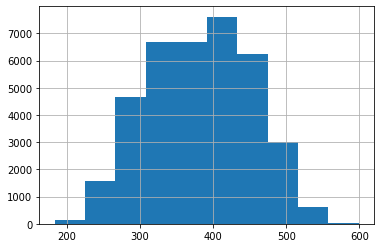

In [ ]:
carga_temp.carga.hist()

- Aqui foi observado que a curva de "val_medicao" seguia uma distribuição normal, então optamos por preencher os valores NA com a média.
Foi observado também que, com a adição da "moda" dos valores de carga, a curva mantinha sua curva de distribuição.

In [72]:
# carga_temp.isna().sum()
carga_temp['val_medicao'].fillna((carga_temp['val_medicao'].median()), inplace=True)
carga_temp['carga'] = carga_temp['carga'].fillna((carga_temp['carga'].mode()))

In [90]:
carga_temp.head()

,id_estacaometeo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga,year,month,day,hora
0,A701,4,17.5,792.06,-23.496294,-46.620087,390,384.777008,2020,6,29,18
1,A707,2,21.6,435.55,-22.119867,-51.408638,5216,402.622009,2020,6,29,18
2,A713,3,19.1,609.00,-23.426111,-47.585556,2937,NaN,2020,6,29,18
3,A725,0,18.4,725.00,-23.101667,-48.941113,69,509.489990,2020,6,29,18
4,A728,5,18.0,571.00,-23.041666,-45.520832,391,NaN,2020,6,29,18


In [91]:
carga_temp.isna().sum()

id_estacaometeo         0
nom_longo               0
val_medicao             0
val_altitude            0
val_latitude            0
val_longitude           0
distribuidora           0
carga              223774
year                    0
month                   0
day                     0
hora                    0
dtype: int64

# ML Modeling

In [95]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

In [96]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({   'Model Name': model_name,'MAE': mae,'MAPE': mape,'RMSE': rmse}, index=[0])

### Colunas a retirar: 'id_estacaometeo', 'id_varmeteo', 'nom_varmeteo', 'din_inclusaodl'

In [94]:
aux1 = carga_temp.copy()

In [98]:
aux1.fillna(0, inplace=True)

In [99]:
aux1.head()

,id_estacaometeo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga,year,month,day,hora
0,A701,4,17.5,792.06,-23.496294,-46.620087,390,384.777008,2020,6,29,18
1,A707,2,21.6,435.55,-22.119867,-51.408638,5216,402.622009,2020,6,29,18
2,A713,3,19.1,609.00,-23.426111,-47.585556,2937,0.000000,2020,6,29,18
3,A725,0,18.4,725.00,-23.101667,-48.941113,69,509.489990,2020,6,29,18
4,A728,5,18.0,571.00,-23.041666,-45.520832,391,0.000000,2020,6,29,18


In [101]:
X = aux1.drop(columns=['id_estacaometeo', 'val_medicao'], axis=1)
y = aux1['val_medicao']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

## Linear Regression Model

In [103]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

score=lr.score(X, y)
print('R2 score: ', score)

# performance
lr_result = ml_error('Linear Regression', y_test, yhat_lr)
lr_result

R2 score:  0.16154805043212195


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,3.468456,0.175827,4.506671


## Random Forest Regressor

In [104]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)
# prediction
yhat_rf = rf.predict(X_test)

score=rf.score(X, y)
print('R2 score: ', score)

# performance
rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)
rf_result

R2 score:  0.9616917424339576


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1.02656,0.048452,1.587287


- Performance do R2 excelente! Vamos verificar as variáveis mais importantes:

In [108]:
importance = rf.feature_importances_

# map feature importance values to the features

feature_importances = zip(importance, X.columns)
# list(feature_importances_)

sorted_featured_importances = sorted(feature_importances, reverse=True)
#print(sorted_featuredfeature_importances)

top_10_predictors = sorted_featured_importances[0:10]
values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print(predictors)

['hora', 'month', 'day', 'val_altitude', 'year', 'val_longitude', 'val_latitude', 'carga', 'distribuidora', 'nom_longo']


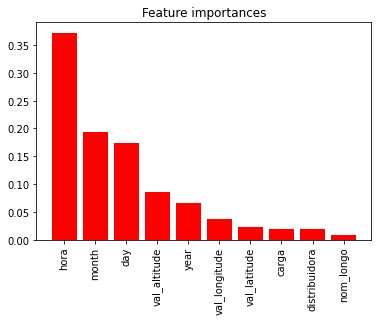

In [109]:
# Plotando a feature importance da floresta
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values, color="r", align="center")
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.show()

## LGBM Regressor

In [107]:
lgbm_model = lgbm.LGBMRegressor(n_estimators=100, learning_rate=0.01, metric='r2')

lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)


score=lgbm_model.score(X, y)
print('R2 score: ', score)

# performance
lgbm_result = ml_error('LGBM Regressor', y_test, y_pred)
lgbm_result


R2 score:  0.5021288904355667


,Model Name,MAE,MAPE,RMSE
0,LGBM Regressor,2.633424,0.134714,3.476608


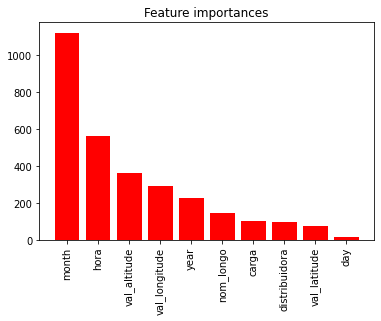

In [111]:
# Plotando a feature importance da LGBM
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values, color="r", align="center")
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.show()

In [110]:
# lgbm_model.feature_importances_

importance = lgbm_model.feature_importances_

# map feature importance values to the features

feature_importances = zip(importance, X.columns)
# list(feature_importances_)

sorted_featured_importances = sorted(feature_importances, reverse=True)
#print(sorted_featuredfeature_importances)

top_10_predictors = sorted_featured_importances[0:10]
values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print(predictors)

['month', 'hora', 'val_altitude', 'val_longitude', 'year', 'nom_longo', 'carga', 'distribuidora', 'val_latitude', 'day']


## XGBoost Regressor

In [114]:
# model
model_xgb = xgb.XGBRegressor(n_estimators=100,
                             n_jobs=-1,
                             eta=0.01,
                             max_depth=5,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(X_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(X_test)

score=model_xgb.score(X, y)
print('R2 score: ', score)

# performance
xgb_result = ml_error('XGBoost Regressor', y_test, yhat_xgb)
xgb_result




R2 score:  -2.236459960308003


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,8.098281,0.348245,8.789234


In [115]:
importance = model_xgb.feature_importances_

# map feature importance values to the features

feature_importances = zip(importance, X.columns)
# list(feature_importances_)

sorted_featured_importances = sorted(feature_importances, reverse=True)
#print(sorted_featuredfeature_importances)

top_10_predictors = sorted_featured_importances[0:10]
values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print(predictors)

['hora', 'val_latitude', 'val_altitude', 'val_longitude', 'month', 'distribuidora', 'carga', 'year', 'nom_longo', 'day']


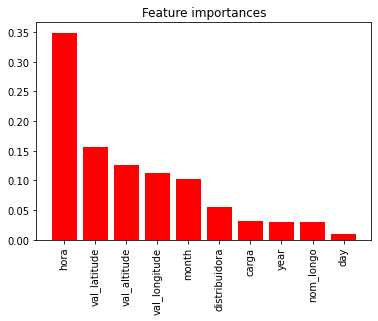

In [116]:
# Plotando a feature importance da floresta
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values, color="r", align="center")
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.show()

- Agora, fazendo predição com os dados teste anteriormente separados!

## - Preprocessing Test (dados futuros)

In [146]:
teste_ins.head()

,id_estacaometeo,nom_longo,din_medicao,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora
0,A701,São Paulo - Mirante de Santana,2022-05-04 00:00:00.000,2022-05-04 03:03:08.000,20.3,792.06,-23.496294,-46.620087,390
1,A701,São Paulo - Mirante de Santana,2022-05-04 01:00:00.000,2022-05-04 04:05:03.000,20.0,792.06,-23.496294,-46.620087,390
2,A701,São Paulo - Mirante de Santana,2022-05-04 02:00:00.000,2022-05-04 05:02:59.000,20.5,792.06,-23.496294,-46.620087,390
3,A701,São Paulo - Mirante de Santana,2022-05-04 03:00:00.000,2022-05-04 06:03:47.000,22.4,792.06,-23.496294,-46.620087,390
4,A701,São Paulo - Mirante de Santana,2022-05-04 04:00:00.000,2022-05-04 07:03:09.000,22.0,792.06,-23.496294,-46.620087,390


In [147]:
teste_ins.rename(columns={'din_medicao': 'data'}, inplace=True)
teste_ins['data'] = pd.to_datetime(teste_ins['data'])

teste_ins['carga'] = teste_ins['distribuidora'].apply(lambda x: 'A701' if x == 'SP-ELETROPAULO' else
                                                                         'A729' if x == 'SP-ELEKTRO' else
                                                                         'A728' if x == 'SP-EDP SP' else
                                                                         'A707' if x == 'SP-ENERGISA SSE-SP'  else
                                                                         'A737' if x == 'SP-CPFL PAULISTA' else
                                                                         'A713' if x == 'SP-CPFL PIRATININGA' else
                                                                         'A725' )

In [148]:
teste_ins.head()

,id_estacaometeo,nom_longo,data,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga
0,A701,São Paulo - Mirante de Santana,2022-05-04 00:00:00,2022-05-04 03:03:08.000,20.3,792.06,-23.496294,-46.620087,390,A725
1,A701,São Paulo - Mirante de Santana,2022-05-04 01:00:00,2022-05-04 04:05:03.000,20.0,792.06,-23.496294,-46.620087,390,A725
2,A701,São Paulo - Mirante de Santana,2022-05-04 02:00:00,2022-05-04 05:02:59.000,20.5,792.06,-23.496294,-46.620087,390,A725
3,A701,São Paulo - Mirante de Santana,2022-05-04 03:00:00,2022-05-04 06:03:47.000,22.4,792.06,-23.496294,-46.620087,390,A725
4,A701,São Paulo - Mirante de Santana,2022-05-04 04:00:00,2022-05-04 07:03:09.000,22.0,792.06,-23.496294,-46.620087,390,A725


In [149]:
carga_teste = pd.merge(teste_ins, cargas, how='left', on=['data', 'distribuidora', 'id_estacaometeo'])

In [150]:
carga_teste.head()

,id_estacaometeo,nom_longo,data,din_inclusaodl,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga_x,carga_y
0,A701,São Paulo - Mirante de Santana,2022-05-04 00:00:00,2022-05-04 03:03:08.000,20.3,792.06,-23.496294,-46.620087,390,A725,NaN
1,A701,São Paulo - Mirante de Santana,2022-05-04 01:00:00,2022-05-04 04:05:03.000,20.0,792.06,-23.496294,-46.620087,390,A725,NaN
2,A701,São Paulo - Mirante de Santana,2022-05-04 02:00:00,2022-05-04 05:02:59.000,20.5,792.06,-23.496294,-46.620087,390,A725,NaN
3,A701,São Paulo - Mirante de Santana,2022-05-04 03:00:00,2022-05-04 06:03:47.000,22.4,792.06,-23.496294,-46.620087,390,A725,NaN
4,A701,São Paulo - Mirante de Santana,2022-05-04 04:00:00,2022-05-04 07:03:09.000,22.0,792.06,-23.496294,-46.620087,390,A725,NaN


In [151]:
carga_teste.drop(columns='din_inclusaodl', axis=1, inplace=True)
carga_teste.drop(columns='carga_x', axis=1, inplace=True)
carga_teste['year'] = carga_teste['data'].dt.year
carga_teste['month'] = carga_teste['data'].dt.month
carga_teste['day'] = carga_teste['data'].dt.day
carga_teste['hora'] = carga_teste['data'].dt.hour
carga_teste.drop(columns='data', axis=1, inplace=True)
carga_teste['nom_longo'] = LabelEncoder().fit_transform(carga_teste['nom_longo'].astype(str))
carga_teste.distribuidora = carga_teste.distribuidora.astype('int64')


In [154]:
carga_teste.isna().sum()

id_estacaometeo        0
nom_longo              0
val_medicao         3904
val_altitude           0
val_latitude           0
val_longitude          0
distribuidora          0
carga_y            12354
year                   0
month                  0
day                    0
hora                   0
dtype: int64

In [158]:
carga_teste.rename(columns={'carga_y':'carga'}, inplace=True)

In [160]:


carga_teste['val_medicao'].fillna((carga_teste['val_medicao'].median()), inplace=True)
carga_teste['carga'] = carga_teste['carga'].fillna((carga_teste['carga'].mode()))

In [162]:
carga_teste.fillna(0, inplace=True)
carga_teste.head()

,id_estacaometeo,nom_longo,val_medicao,val_altitude,val_latitude,val_longitude,distribuidora,carga,year,month,day,hora
0,A701,4,20.3,792.06,-23.496294,-46.620087,390,360.43399,2022,5,4,0
1,A701,4,20.0,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,1
2,A701,4,20.5,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,2
3,A701,4,22.4,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,3
4,A701,4,22.0,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,4


In [163]:
Xtestex = carga_teste.drop(columns=['id_estacaometeo', 'val_medicao'], axis=1)

In [164]:
Xtestex.head()

,nom_longo,val_altitude,val_latitude,val_longitude,distribuidora,carga,year,month,day,hora
0,4,792.06,-23.496294,-46.620087,390,360.43399,2022,5,4,0
1,4,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,1
2,4,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,2
3,4,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,3
4,4,792.06,-23.496294,-46.620087,390,0.00000,2022,5,4,4


## Predição pros dados futuros

In [165]:
lr = LinearRegression().fit(X, y)
yhat_lr = lr.predict(Xtestex)
score=lr.score(X, y)
print('Linear Regression R2 score: ', score)

Linear Regression R2 score:  0.1615589281544052


In [166]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X, y)
# prediction
yhat_rf = rf.predict(Xtestex)

score=rf.score(X, y)
print('Random Forest R2 score:', score)

Random Forest R2 score:  0.9866835560349775


In [168]:
##################################################
lgbm_model.fit(X, y) 
predictions = lgbm_model.predict(Xtestex)
score = lgbm_model.score(X, y)
print('LGBM R2 score: ', score)

LGBM R2 score:  0.5028725235565468


In [169]:
##################################################
model_xgb = xgb.XGBRegressor(n_estimators=100,
                             n_jobs=-1,
                             eta=0.01,
                             max_depth=5,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(X, y)
yhat_xgb = model_xgb.predict(Xtestex)
score=model_xgb.score(X, y)
print('XGB R2 score: ', score)

XGB R2 score:  -2.238123367746634


Optamos pelo modelo de Random Forest para realizar as previsões.

In [172]:
importance = rf.feature_importances_

# map feature importance values to the features

feature_importances = zip(importance, X.columns)
# list(feature_importances_)

sorted_featured_importances = sorted(feature_importances, reverse=True)
#print(sorted_featuredfeature_importances)

top_10_predictors = sorted_featured_importances[0:10]
values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]
print(predictors)

['hora', 'month', 'day', 'val_latitude', 'year', 'val_altitude', 'val_longitude', 'carga', 'distribuidora', 'nom_longo']


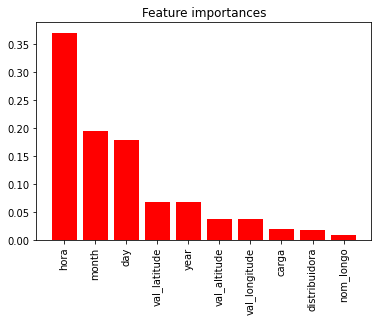

In [173]:
# Plotando a feature importance da floresta
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values, color="r", align="center")
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.show()